In [70]:
#Sourced from https://www.tensorflow.org/tutorials/generative/dcgan
import tensorflow as tf


In [71]:
tf.__version__

'2.8.0'

In [72]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\sonic\appdata\local\temp\pip-req-build-2m21tlgt
  Resolved https://github.com/tensorflow/docs to commit 8da374f11da77d42ec867c82c39e0b715c02dc37
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\sonic\AppData\Local\Temp\pip-req-build-2m21tlgt'


In [73]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display


In [74]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Convert image to float32 tensors
  input_image = tf.cast(image, tf.float32)

  return input_image

# Normalizing the images to [-1, 1]
def normalize(input_image):
  input_image = (input_image / 127.5) - 1
  return input_image

In [75]:
def load_image_train(image_file):
  input_image = load(image_file)
  input_image = normalize(input_image)

  return input_image

def load_image_test(image_file):
  input_image = load(image_file)
  input_image = normalize(input_image)

  return input_image

In [81]:
# import images from gan_data pipeline

PATH = "./gan_data"

# The facade training set consist of 400 images
BUFFER_SIZE = 56576
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 256
# Size you want images to be
IMG_WIDTH = 64
IMG_HEIGHT = 64

train_dataset = tf.data.Dataset.list_files('./gan_data/clouds/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


Generator Model:

In [104]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64*64*256, use_bias=False, input_shape=(500,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((64, 64, 256)))
    assert model.output_shape == (None, 64, 64, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 256, 256, 3)

    return model

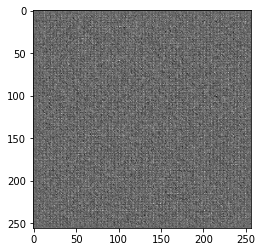

In [105]:
generator = make_generator_model()

noise = tf.random.normal([1, 500])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Discriminator Model:

In [119]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [120]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00072763]], shape=(1, 1), dtype=float32)


Define Loss Function

In [121]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [109]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [110]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [111]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [112]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


Training Loop

In [123]:
EPOCHS = 100
noise_dim = 500
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [124]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [125]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [126]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='rgb')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Training the Model

In [127]:
train(train_dataset, EPOCHS)

In [33]:
# Restore the latest checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Creating a Gif

In [25]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [26]:
display_image(EPOCHS)

FileNotFoundError: [Errno 2] No such file or directory: 'image_at_epoch_0050.png'

In [27]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)



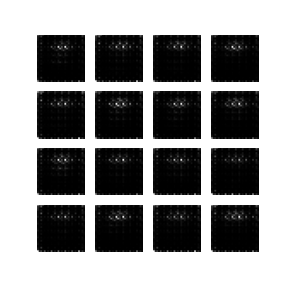

In [28]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)
